# Lab 1

<b>Class:</b> MSDS 7331 Data Mining
<br> <b>Dataset:</b> Belk Endowment Educational Attainment Data 

<h1 style="font-size:150%;"> Teammates </h1>
Maryam Shahini
<br> Murtada Shubbar
<br> Michael Toolin
<br> Steven Millett

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import math
import re
import statistics
from IPython.display import display, HTML

%matplotlib inline

In [69]:
#
# The 2017 Public Schools Machine Learning Date Set is being used throughout this analysis.  The _ML suffix is removed to less name space size
#
# Load Full Public School Data Frames for each year

school_data = pd.read_csv('./Data/2017/machine Learning Datasets/PublicSchools2017_ML.csv', low_memory=False)

# Business Understanding 

The North Carolina General Assembly passed legislation in 2014-2014 requiring the assignment of School Performance Grades (SPG) for public and charter Schools [1].  This data set is collected in response to this legislation.  A school's SPG is calculated using 80% of the school’s achievement score and 20% of the school’s growth score.  The achievement score is calculated through a variety of student testing and the growth score is calculated using the EVASS School Accountability Growth Composite Index [2]. Schools are assigned a letter grade where A: 100-85 points, B: 84-70 points, C: 69-55 points, D: 54-40 points and F: less than 40 points.  Schools that receive grades of D or F are required by to inform parents of the school district.  In 2016, the North Carolina General Assembly passed legislation creating the Achievement School District(ASD). This school district is run by a private organization and are run as charter schools [3].

This data set contains 334 features describing 2,443 schools.  The data includes testing results used to derive the SPG described above.  It also contains school financial data, demographic information, attendance, and student behavior data measured by metrics such as suspension and expulsions. We can look into all these different types of information to see if any correlation with school performances exists, both good and bad.  Do poorly performing schools line up with any specific demographics?  Are there school financial situations that help attribute to a school’s performance? Finding correlations of this data with SPG and being able to use that information in a predictive analysis algorithm may help educators identify schools before the performance metrics deteriorate, allowing them to intervene. The end result of all the testing and analysis is providing all students a fair and equal opportunity at a quality education.

We are examining this data set from the point of view of trying find correlations with SPG Score for each LEA.  SPG Score is a continuous variable, but there is also a group of categorical variables describing SPG Score.  We are choosing to examine the data from continuous variable point of view, although at times we do use the categorical group for certain visualizations. This choice leads us to a use regression model, where we can validate that model with 'k-fold' cross validation for accuracy.

[1] source: http://schools.cms.k12.nc.us/jhgunnES/Documents/School%20Performance%20Grade%20PP%20January%2014,%202015%20(1).pptx<br>
[2] (EVASS Growth information available at http://www.ncpublicschools.org/effectiveness-model/evaas/selection/)<br>
[3] source: https://www.ncforum.org/committee-on-low-performing-schools/

###citation: Drew J., The Belk Endowment Educational Attainment Data Repository for North Carolina Public Schools, (2018), GitHub repository, https://github.com/jakemdrew/EducationDataNC


# Data Meaning Type 


The comprehensive description of all 334 attributes can be found in the data-dictionary.pdf associated with the NC Report Card database provided by Dr. Drew. We were interested in 60 variables moving forward in the course. We visualize several attributes of interest in this report. The most interesting relationships will be between funding, race, and achievement scores. 

<img src="files/data_meaning.jpg"> 

In [3]:
school_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443 entries, 0 to 2442
Data columns (total 334 columns):
student_num                                                     float64
lea_avg_student_num                                             float64
st_avg_student_num                                              float64
00_Size                                                         float64
02_Size                                                         float64
03_Size                                                         float64
04_Size                                                         float64
05_Size                                                         float64
Math I_Size                                                     float64
lea_total_expense_num                                           float64
lea_salary_expense_pct                                          float64
lea_services_expense_pct                                        float64
lea_supplies_expense_pct    

# Data Quality



## Identify Missing Values if Any:
Tried to identify the columns with missing values. There is no missing values in our dataset to worry about.

In [4]:
# to find the missing values if any:
#Print out all the missing value rows
pd.set_option('display.max_rows', 10000)

print('\r\n**The Remaining Missing Values Below will be set to Zero!**')

#Check for Missing values 
missing_values = school_data.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values



**The Remaining Missing Values Below will be set to Zero!**


,Variable Name,Number Missing Values


### Null Value Analysis
The dataset that was chosen has already had all missing values replaced by zero or average values. As well, any columns that were highly correlated to other columns were removed. All of this initial work will make it easier when creating machine learning models but doing so blindly can create errors later on because assumptions may be made that rely on the sparsely populated variables. In certain circumstances other techniques may be better used to impute the missing value or it may be better to drop the variable from all consideration of being used in a model. This determination would need to be made on a case-by-case though. 

Further analysis is done to see how many variables are populated by zero values along with seeing the chance of the variable having an outlier. 

In [5]:
from scipy import stats

def getNumOfOutliers(row, avg, std, alpha=.05):
    x = 0
    for cell in row:
        if (cell>avg+std*stats.t.ppf(1-alpha, 999)) or (cell<avg-std*stats.t.ppf(1-alpha, 999)):
            x=x+1
    return x

def getNumOfZeroes(row):
    x = 0
    for cell in row:
        if cell==0:
            x=x+1
    return x

In [6]:
outlier_plot = school_data.loc[:,school_data.dtypes==float].columns

outlier_mean = school_data[outlier_plot].apply(lambda row: statistics.mean(row))

outlier_data = pd.DataFrame(data={'mean':outlier_mean},index=outlier_plot)

outlier_data['std'] = school_data[outlier_plot].apply(lambda row: statistics.stdev(row))

In [7]:
#Note this section is time intensive, it can take 5 minutes to run. 
#Here is the offending, that takes a while to run.
outlier_data['NumberOfOutliers'] = school_data[outlier_plot].apply(lambda row: getNumOfOutliers(row, statistics.mean(row),statistics.stdev(row),.001 ))
outlier_data['NumberOfExtremeOutliers'] = school_data[outlier_plot].apply(lambda row: getNumOfOutliers(row, statistics.mean(row),statistics.stdev(row),.0000000000000001 ))

In [8]:
outlier_data['NumberOfZeroes'] = school_data[outlier_plot].apply(lambda row: getNumOfZeroes(row))
outlier_data['PctOfZeroes'] = school_data[outlier_plot].apply(lambda row: getNumOfZeroes(row)/school_data.shape[0])

In [9]:
outlier_data = outlier_data.sort_values(by='NumberOfOutliers',ascending=False)
display(HTML(outlier_data.head(10).to_html()))

,mean,std,NumberOfOutliers,NumberOfExtremeOutliers,NumberOfZeroes,PctOfZeroes
lea_wap_num,2872.575522,3443.881421,170,0,0,0.000000
EVAAS Growth Score,73.093287,21.174384,142,0,142,0.058125
avg_age_media_collection,1891.305362,453.908581,133,0,132,0.054032
EOGScienceGr5&8_CACR_Asian,5.925665,21.820418,131,0,2267,0.927957
SPG Score,60.911584,19.573094,130,0,130,0.053213
st_avg_daily_attend_pct,0.946440,0.001657,124,0,0,0.000000
EOGGr4_CACR_Asian,5.630332,20.015799,123,0,2246,0.919361
EOGGr3_CACR_Asian,5.645190,20.035128,120,0,2242,0.917724
EOGGr5_CACR_Asian,7.105280,22.392866,117,0,2199,0.900123
EOCSubjects_CACR_Asian,6.611707,21.893551,108,0,2220,0.908719


In [10]:
outlier_data = outlier_data.sort_values(by='NumberOfZeroes',ascending=False)
display(HTML(outlier_data.head(10).to_html()))

,mean,std,NumberOfOutliers,NumberOfExtremeOutliers,NumberOfZeroes,PctOfZeroes
expelled_per_c_num,0.000679,0.012287,12,5,2431,0.995088
Not Demostrated_TCHR_Standard 1_Pct,0.000187,0.002786,15,7,2428,0.993860
EOCMathI_CACR_AmericanIndian,0.366721,4.379259,20,12,2422,0.991404
EOGReadingGr5_CACR_LEP,0.113672,1.277279,26,7,2417,0.989357
Not Demostrated_TCHR_Standard 2_Pct,0.000806,0.012306,13,4,2417,0.989357
EOGReadingGr5_CACR_AmericanIndian,0.232214,2.329169,27,14,2416,0.988948
EOGReadingGr5_GLP_AmericanIndian,0.395866,3.979682,26,17,2416,0.988948
EOGMathGr5_CACR_AmericanIndian,0.348670,3.659020,25,13,2416,0.988948
EOGScienceGr5_CACR_AmericanIndian,0.507450,5.041678,27,17,2415,0.988539
EOGMathGr4_CACR_AmericanIndian,0.381334,3.782239,27,14,2414,0.988129


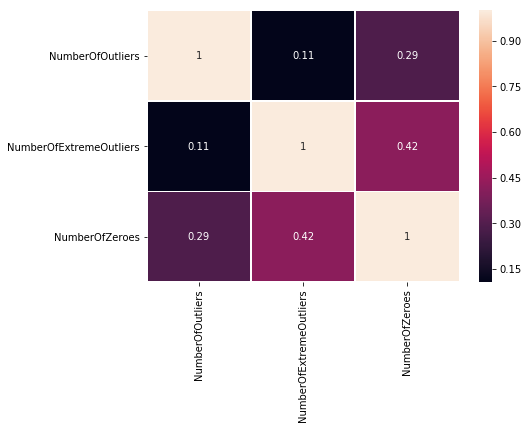

In [11]:
plt.figure(figsize = (7,5)) #size of matrix 
sns.heatmap(outlier_data[['NumberOfOutliers','NumberOfExtremeOutliers','NumberOfZeroes']].corr(),linewidths=0.5, annot=True); #add correrlation inside boxes

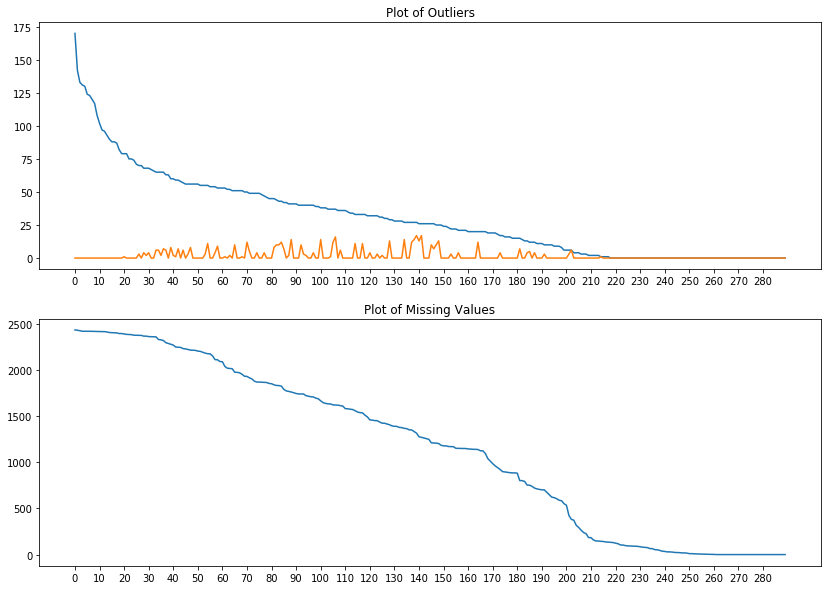

In [12]:
from matplotlib import pyplot as plt

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,10))

outlier_data = outlier_data.sort_values(by='NumberOfOutliers',ascending=False)

ax1.set_title('Plot of Outliers')
ax1.plot(outlier_data['NumberOfOutliers']);
ax1.plot(outlier_data['NumberOfExtremeOutliers']);

outlier_data = outlier_data.sort_values(by='NumberOfZeroes',ascending=False)


ax2.set_title('Plot of Missing Values')
ax2.plot(outlier_data['NumberOfZeroes']);

#Setting range of ticks for x axis
ax1.set_xticks(np.arange(0,outlier_data.shape[0],10))
ax1.set_xticklabels(np.arange(0,outlier_data.shape[0],10 ))
ax2.set_xticks(np.arange(0,outlier_data.shape[0],10))
ax2.set_xticklabels(np.arange(0,outlier_data.shape[0],10 ))
plt.show();

### Analysis of missing values and outliers
For the outliers a confidence interval was constructed for each variable and an alpha value was set to see how many values fell outside of the CI, assuming a normal distribution. Two intervals were considered of a = .001 and a = 1 * e-16, the second value being used to capture all extreme outliers that may indicate issues with the underlying data.

A simple counter was created that tracked the number of zeroes per variable. Some categories had over 99% mix of zeroes, with expelled_per_c_num being having the highest rate of zero values; some of the other top variables with missing values reference the demographic group of American Indians. All of these instances would seem to indicate a small instance of these happening in the population, rather that being improperly recorded. 

Between the outliers, extreme outliers, and population of zeroes, we see the largest correlation between extreme outliers and the number of zeroes. It is believed that this is because the variables with the highest number of outliers, didn’t have any extreme outliers and many also had a small percentage of zeroes. 

 From our analysis it would seem there would need to be a focus on ensuring that American Indian populations are properly tracked to ensure their representation accurately reflects the community’s demographics. Further study could be done to track the demographics of schools and document how well they match the surrounding community.

# Simple Statistics



In [13]:
school_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
student_num,2443.0,584.173966,386.933479,5.000,337.500000,512.000000,725.000000,2974.000000
lea_avg_student_num,2443.0,584.245600,271.986506,5.000,427.500000,529.000000,683.000000,1852.000000
st_avg_student_num,2443.0,586.074089,150.150219,278.000,490.000000,490.000000,629.000000,853.000000
00_Size,2443.0,9.969709,9.588669,0.000,0.000000,14.000000,19.000000,27.000000
02_Size,2443.0,10.153090,9.756678,0.000,0.000000,14.000000,20.000000,28.000000
03_Size,2443.0,10.067131,9.756138,0.000,0.000000,14.000000,20.000000,40.000000
04_Size,2443.0,11.209578,10.842040,0.000,0.000000,15.000000,21.000000,44.000000
05_Size,2443.0,11.152272,11.173440,0.000,0.000000,14.000000,22.000000,68.000000
Math I_Size,2443.0,8.808023,11.225975,0.000,0.000000,0.000000,19.000000,42.000000
lea_total_expense_num,2443.0,9337.465980,1014.397854,8150.840,8731.670000,9008.240000,9740.490000,17718.540000


In [14]:
school_data_simple = school_data[['SPG Score','lea_avg_student_num','student_num']]
school_data_simple.describe()

,SPG Score,lea_avg_student_num,student_num
count,2443.000000,2443.000000,2443.000000
mean,60.911584,584.245600,584.173966
std,19.573094,271.986506,386.933479
min,0.000000,5.000000,5.000000
25%,53.000000,427.500000,337.500000
50%,64.000000,529.000000,512.000000
75%,73.000000,683.000000,725.000000
max,100.000000,1852.000000,2974.000000


### Simple Statistics on SPG Score, and number of students in schools
The table above show us statistics for SPG.  Understanding the mean SPG score is 60.91, which is in the lower part of the "C" range.  The median SPG score
is 64.00, also in "C" range.  It is surprising to see a maximum SPG score of 100 as this indicates perfect scoring for some individual school.  Also the minimum score of 0 mean total failure in testing.  Both of these data points require more investigation to see if see if there are any errors in the data and where these points come from.

In [15]:
# Find the schools whose SPG =1 00
school_SPG_100 =(school_data.loc[school_data['SPG Score'] == 100])
print (school_SPG_100['unit_code'])

371    190501
Name: unit_code, dtype: int64


The school with unit code 190501 has a perfect SPG. The data in this field should be examined for errors or to understand why they received a perfect SPG.

In [16]:
# Find the schools whose SPG = 0  Purposely coded different than above to show various coding techniques
school_SPG_0 =(school_data['unit_code'].loc[school_data['SPG Score'] == 0])
print (school_SPG_0)

24       10378
51       40305
74       60334
77       70302
79       70310
115     100308
131     110303
169     110432
184     120308
199     120352
221     130317
238     130336
259     140306
260     140307
291     160309
317     180323
356     190310
379     200322
389     210316
401     230330
414     230359
442     241312
444     241320
470     260302
498     260363
509     260374
530     260412
531     260413
544     260432
550     260449
569     280306
583     290310
585     290314
617     291348
618     291350
624     300306
666     320322
673     320336
677     320341
726     340336
727     340344
741     340385
744     340398
752     340427
756     340436
787     340531
820     360338
828     360372
834     360394
842     360430
861     360499
879     390314
899     400321
929     410379
937     410396
964     410457
965     410458
970     410464
998     410533
999     410534
1045    430304
1054    430340
1056    430345
1064    430368
1076    440326
1106    450343
1127    47

The list above shows 130 schools with SPG = 0.  This is more problematic than the single school whose SPG = 100.  Nonetheless we need to understand why 130 schools had an SPG = 0 and requires future investigation.

In [17]:
school_data_finance = school_data[['lea_total_expense_num','lea_salary_expense_pct',
                                  'lea_services_expense_pct', 'lea_supplies_expense_pct',
                                  'lea_instruct_equip_exp_pct']]
school_data_finance.describe()

,lea_total_expense_num,lea_salary_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,lea_instruct_equip_exp_pct
count,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000
mean,9337.465980,0.834615,0.079380,0.076526,0.009479
std,1014.397854,0.024518,0.015031,0.015094,0.006666
min,8150.840000,0.761000,0.052000,0.028000,0.001000
25%,8731.670000,0.816000,0.069000,0.069000,0.006000
50%,9008.240000,0.835000,0.079000,0.078000,0.009000
75%,9740.490000,0.852000,0.085000,0.091000,0.012000
max,17718.540000,0.878000,0.148000,0.117000,0.045000


Looking at the expenses, the LEA with largest number of expenses is 90% higher than the mean for all LEA's in the state.  All other quantiles are closer to the mean, indicating a good chance this in outlier.  We will look for this school to see if there are errors in the data and consider how to handle this.

In [18]:
# Add
# Find the schools whose SPG = 0  Purposely coded different than above to show various coding techniques
school_lea_exp_max =(school_data['unit_code'].loc[school_data['lea_total_expense_num'] == 17718.54])
print (school_lea_exp_max)

1132    480306
1133    480316
1134    480318
Name: unit_code, dtype: int64


It is interesting to note that three LEA's have the same exact expense number and that number is the maximum that appears in the data set.  Understanding this is an area for future investigation.

In [19]:
demog_male_cols = [col for col in school_data.columns if "Male" in col]
demog_female_cols = [col for col in school_data.columns if "male" in col]
school_data_demog_male = school_data[np.intersect1d(school_data.columns, demog_male_cols)]
school_data_demog_female = school_data[np.intersect1d(school_data.columns, demog_female_cols)]
school_data_demog_all = pd.concat([school_data_demog_female, school_data_demog_male], axis=1)
school_data_demog = school_data_demog_all.filter(regex='^(?!(EOC|Two).*?)') 

school_data_demog.describe()

,AsianFemalePct,BlackFemalePct,HispanicFemalePct,IndianFemalePct,MinorityFemalePct,PacificIslandFemalePct,AsianMalePct,BlackMalePct,HispanicMalePct,MinorityMalePct,PacificIslandMalePct
count,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000,2443.000000
mean,0.012284,0.128583,0.082390,0.006774,0.250685,0.000643,0.012858,0.136726,0.085380,0.263320,0.000647
std,0.023180,0.113157,0.063890,0.031991,0.135215,0.001643,0.025016,0.123180,0.065805,0.145042,0.001948
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.035782,0.037125,0.000000,0.139039,0.000000,0.000000,0.037559,0.038503,0.140693,0.000000
50%,0.004902,0.100719,0.064240,0.000897,0.237443,0.000000,0.004967,0.105263,0.066986,0.247166,0.000000
75%,0.013634,0.195891,0.110004,0.003115,0.356408,0.000000,0.014103,0.206682,0.113101,0.376314,0.000000
max,0.316042,0.861386,0.419355,0.450413,0.970297,0.037162,0.338136,0.910569,0.412442,1.000000,0.057432


The above table shows actual quantile breakdown by minority demographics.  It is interesting to note there is at least one LEA that has 0 minorities and at least one where the entire male population is made up of minorities.  Identifying these LEA's may provide some information.

# Visualize Attributes



## Educator Experience

In [20]:
def prefixsearch(search_string, missing_value ,start_of_search_string,end_of_search_string):
    if re.search(end_of_search_string, search_string):
        return re.search('('+ start_of_search_string +'\S*)(?='+ end_of_search_string +')',search_string).group(0)
    else:
        return missing_value

In [21]:
teacher_temp_col = [col for col in school_data.columns if 'tchyrs' in col]
teacher_columns = school_data[teacher_temp_col].melt(var_name='col',value_name='Percent')

teacher_columns['Year'] = teacher_columns['col'].apply(lambda name: re.search('(?<=tchyrs_)\S*(?=_)',name).group(0))
teacher_columns['Region'] = teacher_columns['col'].apply(lambda name: prefixsearch(name, "Sch", '^\S*','_tch'))

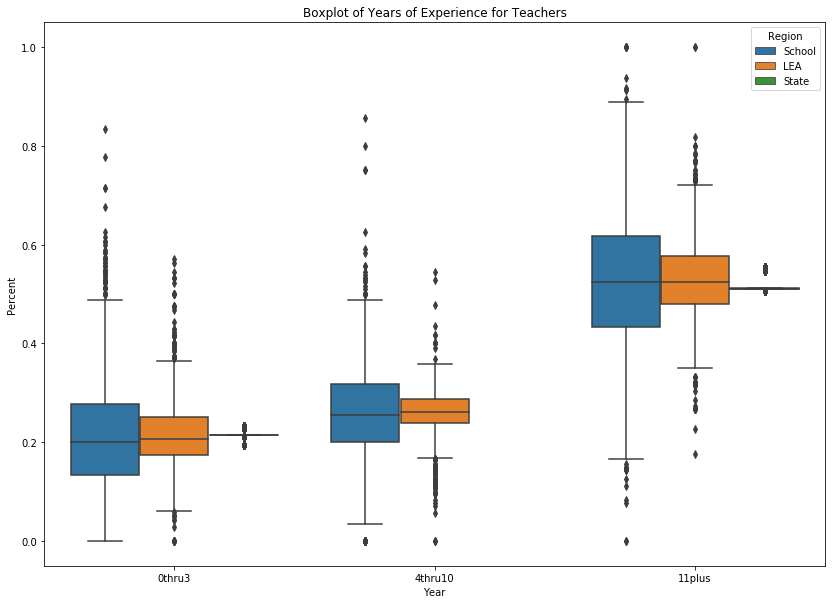

In [22]:
a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)
leg_labels = ['School','LEA','State']
plt.title('Boxplot of Years of Experience for Teachers')

g = sns.boxplot(ax=ax,data=teacher_columns,x='Year', y='Percent', hue='Region')
for t, l in zip(g.legend_.texts, leg_labels):t.set_text(l)

### Make up of teachers in classrooms
In the graph above we are looking at the percentage of teachers that make up a classroom based on their years of tenure.  North Carolina has relatively experienced teaching staff.  We can guess that teachers with less experience are younger than those with more experience. The number of teachers with 0-3 years of experience could be an issue as older teachers start to retire and move out of the education system.  Perhaps a teacher recruiting campaign across the state will be needed in the upcoming years.  It also appears there is at least one school where all the teachers have 11 plus years of experience, and at least one school with more than 80% teachers 0 thru 3 years experience.  Future investigation may want to compare these two schools to see if there are any interesting differences in test scoring or other important statistics. 

## Makeup of minorities in classrooms

In [23]:
sex_temp_col = school_data.filter(regex=('[Mm]alePct')).columns
sex_teacher_columns = school_data[sex_temp_col].melt(var_name='col',value_name='Percent')

sex_teacher_columns['Race'] = sex_teacher_columns['col'].apply(lambda name: prefixsearch(name, "", '^','Male|Female'))
sex_teacher_columns['Sex'] = sex_teacher_columns['col'].apply(lambda name: 'Female' if re.search('Female',name) else 'Male')

my_order = ['PacificIsland','Indian','Asian','TwoOrMore','Hispanic','Black','Minority']

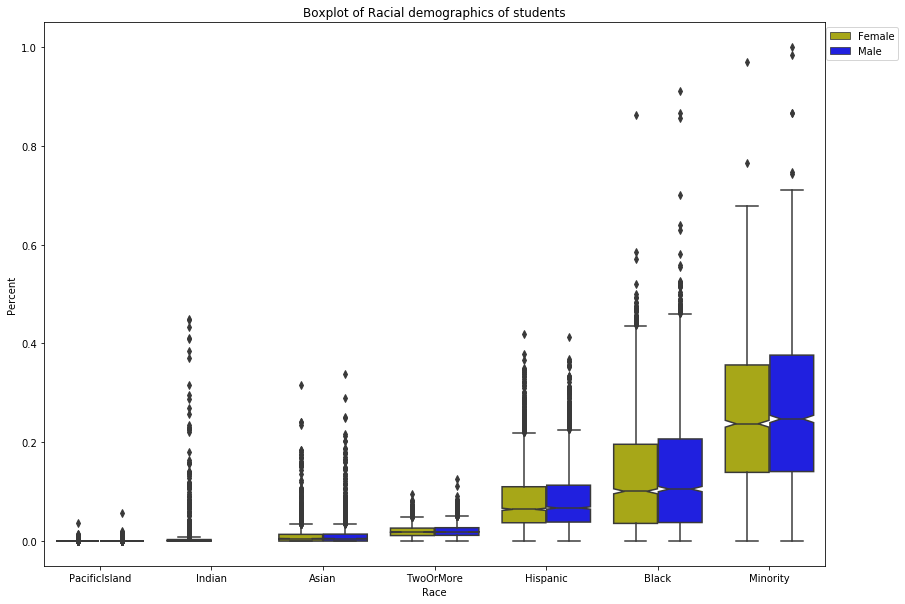

In [24]:
a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(ax=ax,x='Race',y='Percent',hue='Sex',data=sex_teacher_columns,notch=True,palette={"Male": "b", "Female": "y"},
              order = my_order);

leg = plt.legend( loc = 'upper right')
plt.title('Boxplot of Racial demographics of students')
plt.draw() # Draw the figure so you can find the positon of the legend. 

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = .1
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)


# Update the plot
plt.show()

### Makeup of minorities in classrooms

We broke down the racial make-up of students in the classroom along with dividing the groups based on sex. It was found that while most schools are still predominantly White, there is a significant mix of minority students, with some schools even being completely classified as minority. This plot validates the earlier observation that there is at least one school where the males are 100% minorities. The largest minority group is Black followed by Hispanic students. 

Although neither group has high density above 50%, Blacks have a higher density across the lower percentage, indicating this group is more spread out across LEAs, where the density of Hispanics is mostly even from about 10% to 50%, indicating the Hispanic group is most likely clumped closer together in LEAs.  We find this similar shape for Asians, where the density is thick at lower percentage value indicating this group is also most likely spread out among LEAs.

It appears that across all demographics there is a higher percentage of male students attending school than female. This should be looked into further as to whether this matches the demographic mix for the local community. If not then there could be instances where females are not attending school when they should. 

## Media and Computer resources available

In [25]:
support_col = school_data.filter(regex=('books|stud_internet')).columns
support_columns = school_data[support_col].melt(var_name='col',value_name='Values')

support_columns = support_columns[support_columns['Values']!=0]

#Converts values to the log 
support_columns['Values'] = support_columns['Values'].apply(lambda value: math.log(value))


#support_columns['media'] = sex_teacher_columns['col'].apply(lambda name: 'Female' if re.search('Female',name) else 'Male')

support_columns['region'] = support_columns['col'].apply(lambda name: prefixsearch(name, "Sch", '^\S*','_books|_stud_int'))
support_columns['media'] = support_columns['col'].apply(lambda name: re.sub('lea_','',name) if re.search('lea',name) else name )
support_columns = support_columns.sort_values(by='Values')
#print(support_columns.sample(20))

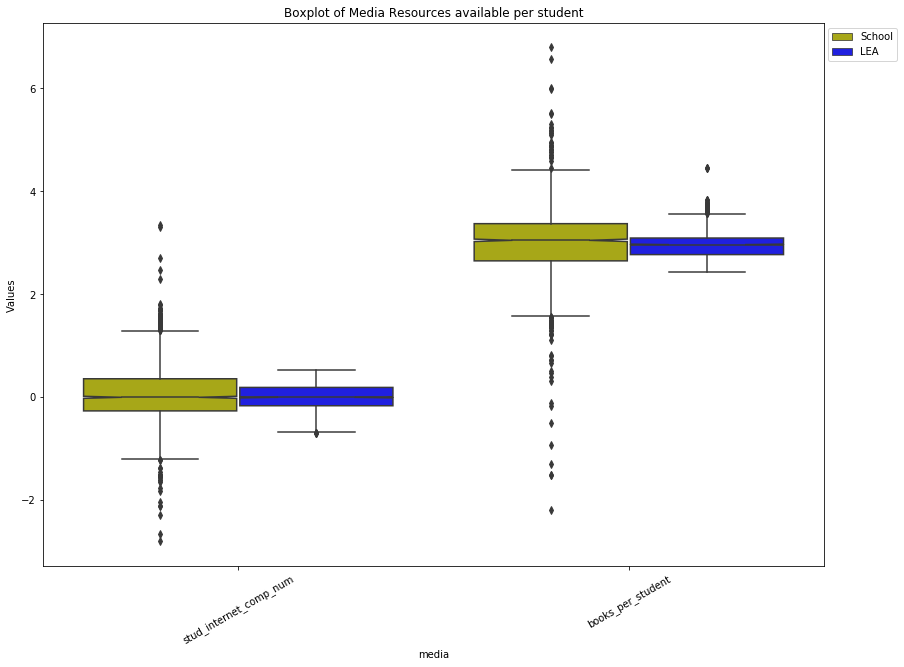

In [26]:
a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(ax=ax,x='media',y='Values',hue='region',data=support_columns,notch=True,
                palette={"lea": "b", "Sch": "y"});
plt.xticks(rotation=30)

plt.title('Boxplot of Media Resources available per student')

leg = plt.legend( loc = 'upper right')

plt.draw() # Draw the figure so you can find the positon of the legend. 

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = .1
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

#Relabeling the items in the legend
leg_labels = ['School','LEA']
for t, l in zip(g.legend_.texts, leg_labels):t.set_text(l)

# Update the plot
plt.show()

### Media resources avaiable to the student body
We wanted to measure the resources available to students including the ratio of students to internet connect computers and the number of books per student. With these categories we found such a wide range of values for the available resources that it was thought to display the log of the number provided. With Student_Internet_Comp_Num we have the ratio of the number of students to the number of internet connected computers, so generally a lower value is better which would indicate there are more computers available. For books_per_student we are tracking the number of books for every student. Some schools seem to have orders of magnitude more books than other schools, which could mean that some schools are incorrectly reporting the number of resource they have or they are severely underfunded.

Going forward it would be interesting to see if these schools are correctly reporting the number of resources. A question to ask for future analysis is do greater number of books or internet connected computers contribute to better student scores?

## Educator Effectivness

In [27]:
TCHR_col = school_data.filter(regex=('TCHR_Standard')).columns
TCHR_columns = school_data[TCHR_col].melt(var_name='col',value_name='Values')


TCHR_columns['Standard'] = TCHR_columns['col'].apply(lambda name: re.search('(?<=TCHR_).*(?=_Pct)',name).group(0))
TCHR_columns['Level'] = TCHR_columns['col'].apply(lambda name: re.search('(?<=^).*(?=_TCHR)',name).group(0))

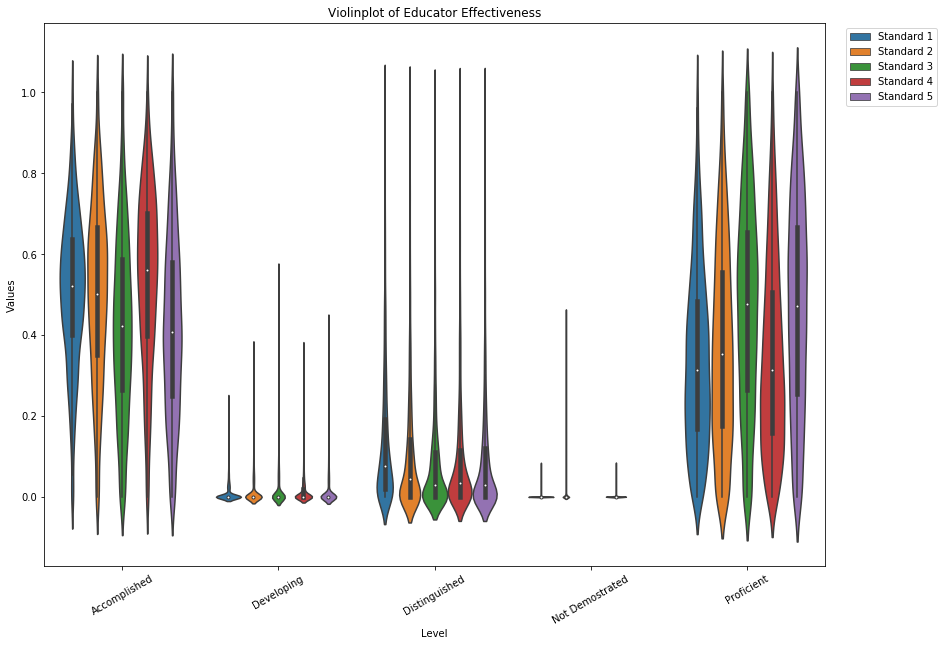

In [28]:
a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.violinplot(ax=ax,x='Level',y='Values',hue='Standard',data=TCHR_columns);
plt.xticks(rotation=30)

plt.title('Violinplot of Educator Effectiveness')

leg = plt.legend( loc = 'upper right')

plt.draw() # Draw the figure so you can find the positon of the legend. 

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = .15
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)


# Update the plot
plt.show()

### Educator Effectiveness
Teachers are evaluated on Standards 1-6, however the data set we used only contained Standards 1-5.  These scores highlight how well teachers understand each of these standards.  The plot above shows the North Carolina teachers have a heavy distribution in the Accomplished and Proficient categories.  There are more teachers in the Distinguished category than the Developing category, leading us to believe the teachers have a solid understanding of the standards they are tested against.  One area to look in the future would be to see if there is any correlation between the Educator Effectiveness and the Makeup of Teachers in the Classroom.

## End-of-Grade Tests Pass Rate

In [29]:
EOG_col = school_data.filter(regex=('EOGG')).columns
EOG_columns = school_data[EOG_col].melt(var_name='col',value_name='Values')

EOG_columns['Grade'] = EOG_columns['col'].apply(lambda name: re.search('(?<=EOG).*(?=_[CG])',name).group(0))
EOG_columns['Level'] = EOG_columns['col'].apply(lambda name: re.split('EOGGr[3-5]_',name)[1])
EOG_columns = EOG_columns.sort_values(by='Grade')

my_order = ['GLP_LEP','CACR_LEP','CACR_SWD','CACR_EDS','CACR_AmericanIndian','CACR_TwoorMoreRaces','CACR_Asian',
           'CACR_Black','CACR_Hispanic','CACR_All','CACR_White','CACR_AIG']

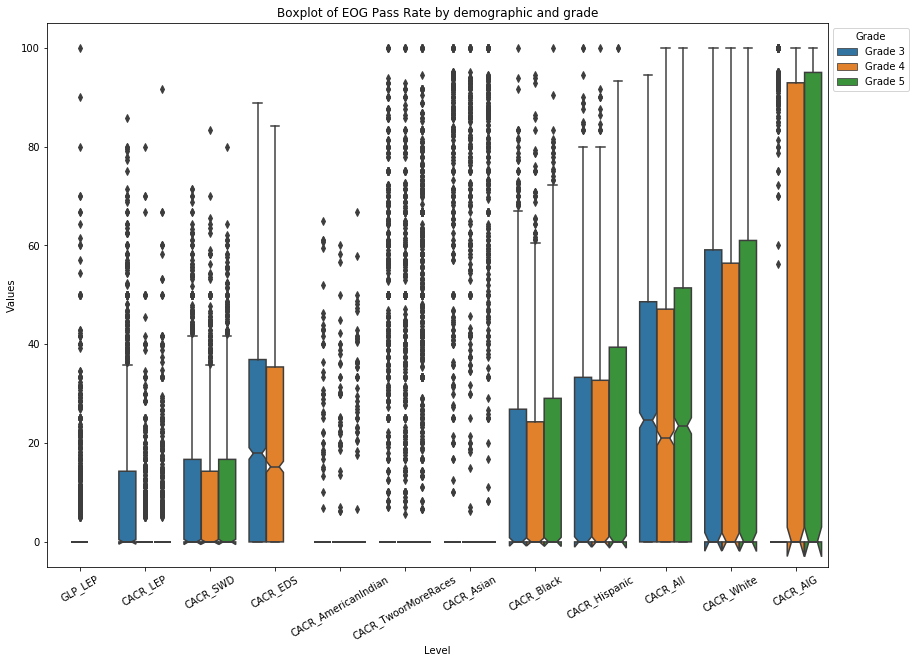

In [30]:
a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)
plot = sns.boxplot(ax=ax,x='Level',y='Values',hue='Grade',data=EOG_columns, notch=True,
                   order =my_order);
plt.xticks(rotation=30)

plt.title('Boxplot of EOG Pass Rate by demographic and grade')

leg = plt.legend( loc = 'upper right',title='Grade')

plt.draw() # Draw the figure so you can find the positon of the legend. 

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = .11
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

#Relabeling the items in the legend
leg_labels = ['Grade 3','Grade 4', 'Grade 5']
for t, l in zip(plot.legend_.texts, leg_labels):t.set_text(l)

# Update the plot
plt.show()

### End-of-Grade Pass Rate analysis
In this section we are comparing the rate of passing the end of grade test with a score of four out of five or higher. This test tracks the ability for students to be able to succeed as they move to higher grades, with a CACR rating meaning the student has a solid or superior command of the knowledge and skills to succeed at the next grade levels. The passing rates were broken out by the grade and tracked demographic group, which includes race and disabilities. It was found that all of the groups with learning disadvantages tended to score poorer than other groups, which include LEP (Limited English Proficiency), SWD (Students with Disabilities), and EDS (Economically Disadvantaged). Not surprisingly the group with the highest level of passing with a rating of CACR are the AIG (Academically/Intellectually Gifted) students.

Among the races, the graph shows that White and Hispanic tend to outperform other racial demographics. In the case of American Indians, Multiracial, and Asian students it appears this is due to limited sample sizes. If a greater sample size could be obtained in the future then more accurate models could be created from the patterns. 

In terms of the year-to-year performance it appears there is a drop in the level of CACR pass rate from Grade 3 to Grade 4, across all demographics. It would be interesting to understand why this drop is there, did the testing change or is there something else to explain this phenomenon.

It should be investigated why there are so many zero values reported with these results. It is suspected that some schools aren’t tracking the demographic breakdowns for students with these low rates of CACR scores.

## End-of-Class Tests Pass Rate

In [31]:
EOC_col = school_data.filter(regex=('^EOC')).columns
EOC_columns = school_data[EOC_col].melt(var_name='col',value_name='Percent')

EOC_columns['Subject'] = EOC_columns['col'].apply(lambda name: re.search('(?<=EOC).*(?=_[CG])',name).group(0))
EOC_columns['Level'] = EOC_columns['col'].apply(lambda name: re.split('EOC(Subjects|MathI)_',name)[2])

my_order = EOC_columns.groupby(by='Level').mean().iloc[::-1].index

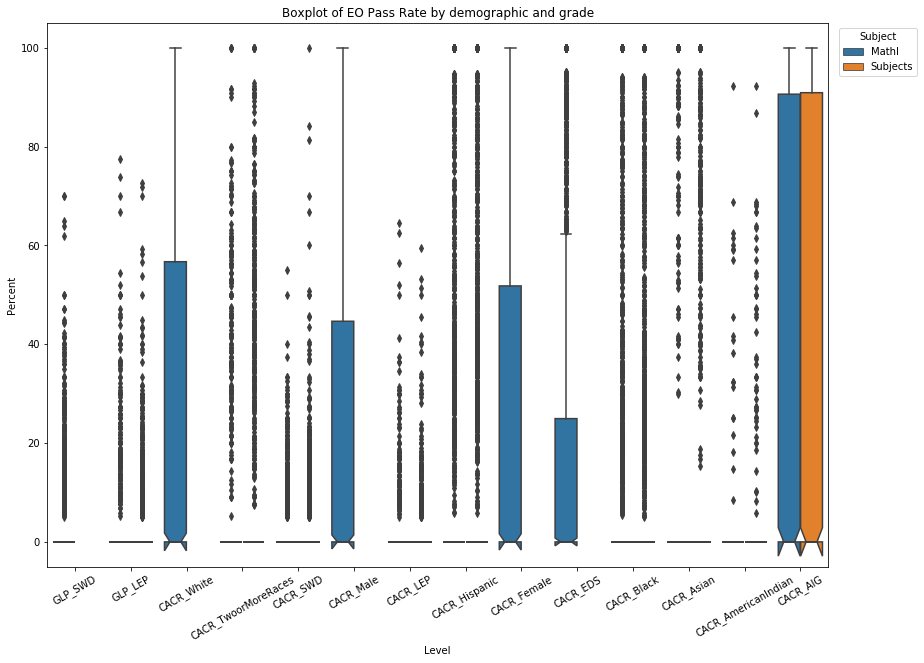

In [32]:
a4_dims = (14, 10)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(ax=ax,x='Level',y='Percent',hue='Subject',data=EOC_columns,notch=True, 
                   order =my_order);
plt.xticks(rotation=30)

plt.title('Boxplot of EO Pass Rate by demographic and grade')

leg = plt.legend( loc = 'upper right',title='Subject')

plt.draw() # Draw the figure so you can find the positon of the legend. 

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = .12
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

#Relabeling the items in the legend
leg_labels = ['Math I','All Subjects']
for t, l in zip(plot.legend_.texts, leg_labels):t.set_text(l)

# Update the plot
plt.show()

### End-of-class pass rate analysis
The plot above is a boxplot of the rate of getting a CACR rating (score of 4 or 5) on the end-of-class (EOC) test broken out but different student demographics and the type of test score tracked. EOC tests are administered for Math I, Biology, and English II which are meant to track their proficiency in those subjects. Many of these scores are highly correlated across test subjects, with Math I and the all subjects score having the largest variance. If it was found that for a given demographic there was little difference, then only the Math pass rate was kept, otherwise both Math I and the all scores pass rate is noted.

There is a dearth of non-zero values for most demographics for these variables. From what is present it is evident that Asian demographics report a higher percentage of getting a CACR rating, while most other demographics show an even distribution across the entire percentage range.  The special needs groups do show a similar trend with lower passing rates for both categories. 

## New Features:
In this study, there are some other new features that are created from the original variables. 
"SPG Grade" and "SPG": the categorical and continous variables created from SP Grade columns.
"AsianPct": the sum of Asian femail and male percentages
"BlackPct": the sum of black male and female percentages
"HispanicPct": the sum of Hispanic male and female percentages
"MinorityPct": the sum of minority male and female percentages

In [33]:
#Created a categorical multiclass variable from SP Grade
SPG_Grade_col = school_data.filter(regex=('^SPG\WGrade')).columns
school_data['SPG Grade']= school_data[SPG_Grade_col].apply(lambda row:'A' if row.any()!=1 else 
                                 row[0]*'A+NG'+row[1]*'B'+row[2]*'C'+row[3]*'D'+row[4]*'F'+row[5]*'I',axis=1)

In [34]:
#insert a new feature for SPG as continous values
school_data['SPG']=6
school_data['SPG'] = school_data['SPG Grade_A+NG']*7 + school_data['SPG Grade_B']*5 + school_data['SPG Grade_C']*4 + school_data['SPG Grade_D']*3 + school_data['SPG Grade_F']*2 + school_data['SPG Grade_I']*1

In [35]:
#Created new variables for different races - Combine the Male and Female for each race
school_data['AsianPct']=school_data['AsianFemalePct']+school_data['AsianMalePct']
school_data['BlackPct']=school_data['BlackFemalePct']+school_data['BlackMalePct']
school_data['HispanicPct']=school_data['HispanicFemalePct']+school_data['HispanicMalePct']
school_data['MinorityPct']=school_data['MinorityFemalePct']+school_data['MinorityMalePct']
school_data['PacificIslandPct']=school_data['PacificIslandFemalePct']+school_data['PacificIslandMalePct']

# Explore Joint Attributes



### Correlation Matrix Heatmap: Funding and SPG scores/Benchmark Tests

The first joint attribute we wanted to explore is the relationship between funding and educational achievement. Educational achievement or success are defined by the following categories: 
SPG Score, Reading SPG Score, EVAAS Growth Score, LEA SAT Average Score Number, LEA SAT Participation Percentage, LEA AP Participation Percentage, and LEA AP Percentage of 3 or Above. 

The Funding attributes looked at a school system wide funding for the following areas: 
Salary Expense percentage, Services Expense Percentage, Supplies Expense Percentage, Instructional Equipment, Federal Spending per Pupil, Local Spending per Pupil, and State Spending per Pupil at an LEA level. 

From a high level view, we see that not only are there no correlations between attributes, but there are negative correlations. It is surprising to see negative to very little correlation between total expense (Dollars spent) at LEA level with SPG scores, reading SPG scores, SAT and AP participation and scores. What is not surprising is the positive correlation between spending more on salaries and the above mentioned educational measurements such as AP scores and participation. 

The AP scores and participation in regards to salary spending is correlated at around 0.50. However, the SPG score is not correlated that high, and is only at 0.15 correlation. Another interesting observation to point out, is that the SPG score correlation with any funding attribute is at its highest with the expenditure spend on salaries. No other funding attribute even comes close. 
  



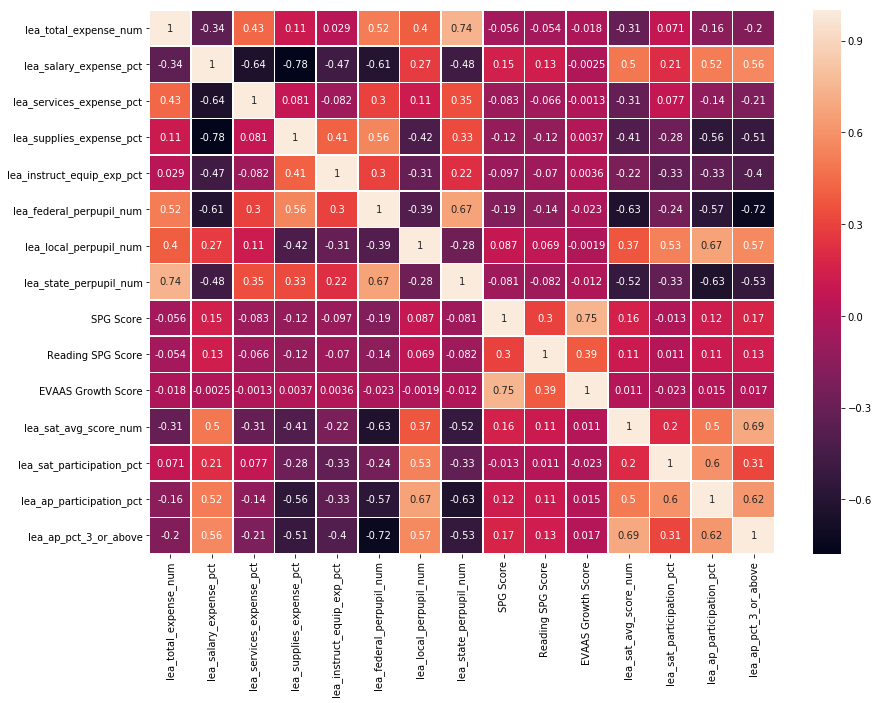

In [36]:
first_heat = school_data[['lea_total_expense_num',
'lea_salary_expense_pct',
'lea_services_expense_pct',
'lea_supplies_expense_pct',
'lea_instruct_equip_exp_pct',
'lea_federal_perpupil_num',
'lea_local_perpupil_num',
'lea_state_perpupil_num',            
'SPG Score',
'Reading SPG Score',
'EVAAS Growth Score',
'lea_sat_avg_score_num',
'lea_sat_participation_pct',
'lea_ap_participation_pct',
'lea_ap_pct_3_or_above',]] 
                       
first_corr = first_heat.corr()

plt.figure(figsize = (14,10)) #size of matrix 
sns.heatmap(first_corr,linewidths=0.5, annot=True); #add correrlation inside boxes

### Correlation Matrix Heatmap: Funding and Attendance/Crime Rate

The second joint attribute we wanted to explore is the relationship between funding and criminal activity/student discipline issues. Criminal activity or discipline issues are defined by the following categories: 
Daily Avg attendance percentage at LEA level, number of crimes or acts of violence per 100 students at LEA level, short term suspensions, long term suspensions, and expulsions per 100 students at an LEA level. 

The Funding attributes looked at a school system wide funding for the following areas: 
Salary Expense percentage, Services Expense Percentage, Supplies Expense Percentage, Instructional Equipment, Federal Spending per Pupil, Local Spending per Pupil, and State Spending per Pupil at an LEA level. 

Again, from a high-level view we see all three types of correlations, negative, none, and positive. Our interest in these attributes stems from background research done on this project that suggests a safe environment comes at a very high priority, not only towards educational success, but also towards human growth. 

Once again, we don’t see any good correlation with most funding attributes towards the average daily attendance except for salary funding. Perhaps we’re identifying a theme here. We also see that there is a negative correlation between salary funding (formally: % of expense spent on salaries at school level) and the number of short term and long-term suspensions on an LEA level. 

This is very interesting since we’ve seen major demonstrations from the teaching workforce in the past 10 years demanding salary raises. Perhaps it is justified using our data.

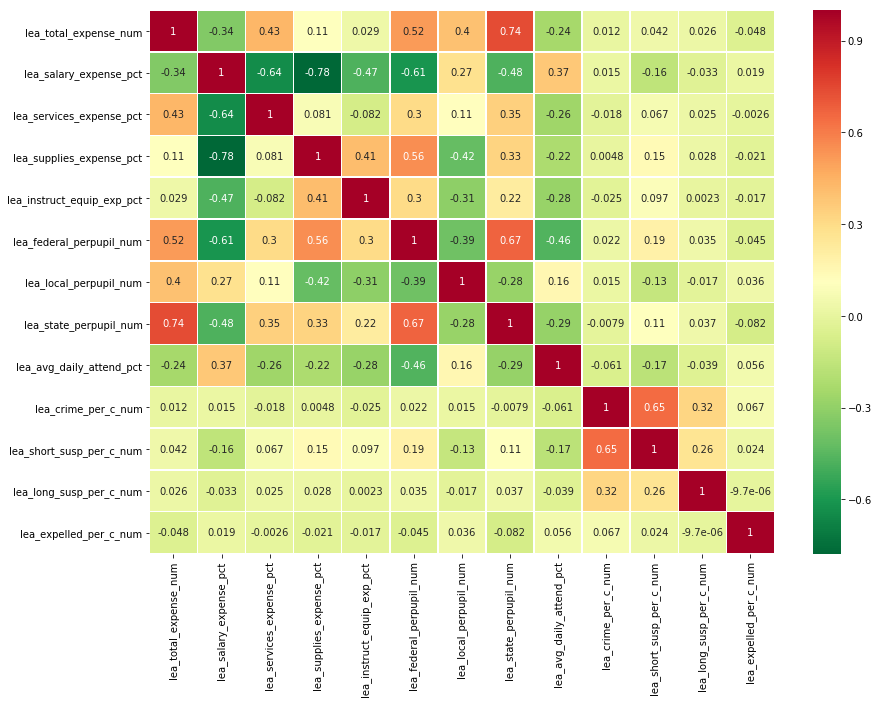

In [37]:
snd_heat = school_data[['lea_total_expense_num',
'lea_salary_expense_pct',
'lea_services_expense_pct',
'lea_supplies_expense_pct',
'lea_instruct_equip_exp_pct',
'lea_federal_perpupil_num',
'lea_local_perpupil_num',
'lea_state_perpupil_num',            
'lea_avg_daily_attend_pct',
'lea_crime_per_c_num',
'lea_short_susp_per_c_num',
'lea_long_susp_per_c_num',
'lea_expelled_per_c_num',]] 

                       
snd_corr = snd_heat.corr()

plt.figure(figsize = (14,10)) #size of matrix 
sns.heatmap(snd_corr,cmap='RdYlGn_r', linewidths=0.5, annot=True); #add correrlation inside boxes

### Correlation Matrix Heatmap: Race, Gender, and Region 

The third attribute we wanted to explore is one suggested by Dr. Drew. The segregation or re-segregation of schools. In this plot we explore the different school district regions and the race and gender of the school population. District regions include: 
Northwest, Piedmont-Triad, Sandhills, Southeast, Southwest, and Western. 

The race and gender percentage attributes include: 
Asian female, Asian male, Black female, Black male, Hispanic female, Hispanic male, Pacific Island female, Pacific Island male, Minority Female, Minority Male. 

From the plot, we can see several relationships between region and racial demographics. The most obvious being the high correlation between the Northeast region and prominent numbers of Black students. In the SandHill region, again Black and Indian students are most popular. From the negative correlation and since the White student group is not added to this plot, I can assume that the Caucasians are most frequent in the Western and North Western regions. I cannot assume however, their relationship to the North Eastern region. It also seems that Hispanic students are distributed in all regions and do not dominate one. 

Adding a bar chart with race percentage would be very helpful in further interpreting this graph. I did not comment on the gender attribute of the population because it seems fairly evenly distributed. 


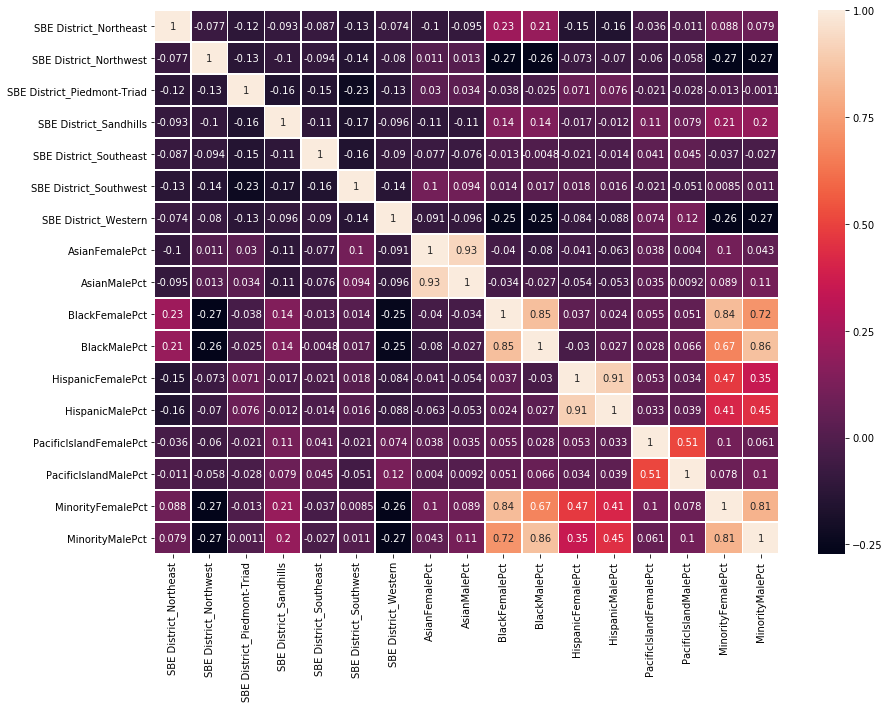

In [38]:
thd_heat = school_data[['SBE District_Northeast',
'SBE District_Northwest',
'SBE District_Piedmont-Triad',
'SBE District_Sandhills',
'SBE District_Southeast',
'SBE District_Southwest',
'SBE District_Western',
'AsianFemalePct',            
'AsianMalePct',
'BlackFemalePct',
'BlackMalePct',
'HispanicFemalePct',
'HispanicMalePct',
'PacificIslandFemalePct',                        
'PacificIslandMalePct',                      
'MinorityFemalePct',
'MinorityMalePct',]] 

                       
thd_corr = thd_heat.corr()

plt.figure(figsize = (14,10)) #size of matrix 
sns.heatmap(thd_corr,linewidths=0.5,annot=True); #add correrlation inside boxes

## Identify highly correlated pairs from the dataset:
This table shows the top 20 pairs with highest absolute correlations. 
We would remove one of each pairs from our analysis during data cleansing and reduction.
By quickly looking at the result, and refer to the data dictionary, there are definitely the strong relationship between each pairs and we do not need to have bouth in our models.

In [70]:
df = pd.DataFrame(data = school_data)

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 20))

Top Absolute Correlations
EOGGr3_CACR_EDS                    EOGMathGr3_CACR_EDS                    0.948930
EOGMathGr3_CACR_SWD                EOGMathGr3_GLP_SWD                     0.948708
EOCMathI_CACR_AIG                  EOCSubjects_CACR_AIG                   0.947644
EOGGr4_CACR_EDS                    EOGMathGr4_CACR_EDS                    0.947576
EOGScienceGr5_CACR_LEP             EOGScienceGr5_GLP_LEP                  0.947263
EOGScienceGr5&8_CACR_LEP           EOGScienceGr5&8_GLP_LEP                0.946923
st_avg_student_num                 st_nbpts_num                           0.945724
EOGGr4_CACR_LEP                    EOGGr4_GLP_LEP                         0.945566
EOG/EOCSubjects_CACR_LEP           EOG/EOCSubjects_GLP_LEP                0.944424
                                   EOGSubjects_CACR_LEP                   0.943502
00_Size                            02_Size                                0.942351
EOGReadingGr5_CACR_AmericanIndian  EOGReadingGr5_GLP_American

# Explore Attributes and Class



## The target variable in this study is "SPG Score" (School Performance Score). 
The below graph illustrate that the majoprity of variables in this research have an absolute correlation factor range of around [0%,25%]. We will analyze the relationships between our interesting variables and target variable in the following graphs.

In [40]:
df=pd.DataFrame(school_data)

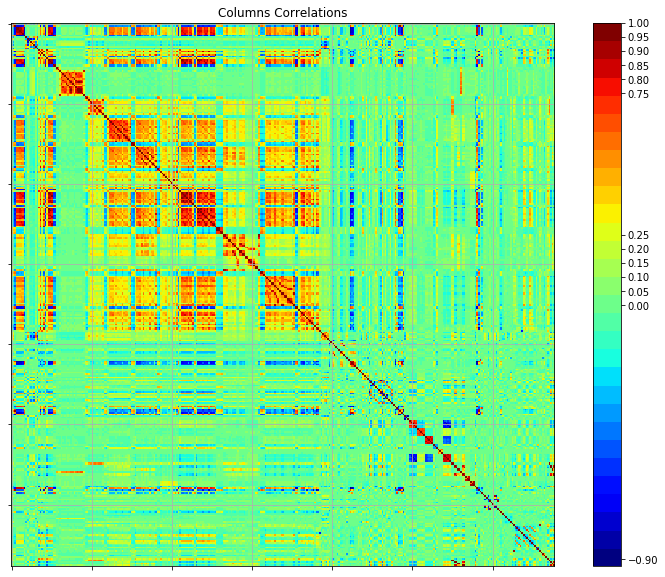

In [41]:
def correlation_matrix(school_data):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm
    
      
    fig=plt.figure(figsize = (14,10))
    ax1=fig.add_subplot(111)
    cmap=cm.get_cmap('jet',30)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    labels=['column_names',]
    plt.title('Columns Correlations')
    ax1.set_xticklabels(labels,fontsize=3)
    ax1.set_yticklabels(labels,fontsize=3)
    # Add colorbar
    fig.colorbar(cax, ticks=[-1,-.95,-.90,0,.05,.1,.15,.2,.25,.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix(df)

## The relationships between SPG Score and Expenses:
Surprisingly, there is no clear relationship between school expenditures and student performances.
We can conclude that school expenditures have only a minor influence on student achievement. Instead, some other factors like variations in family background and in the backgrounds of other students in the school might be one of the primary determinants of students' performance.
Today, inner-city schools typically spend at least 50% more on per pupil expenditures than the U.S. average, yet these schools are failures by almost any measure. This suggests that spending more on a school does not necessarily mean that its students will learn more and school has a better performance. 

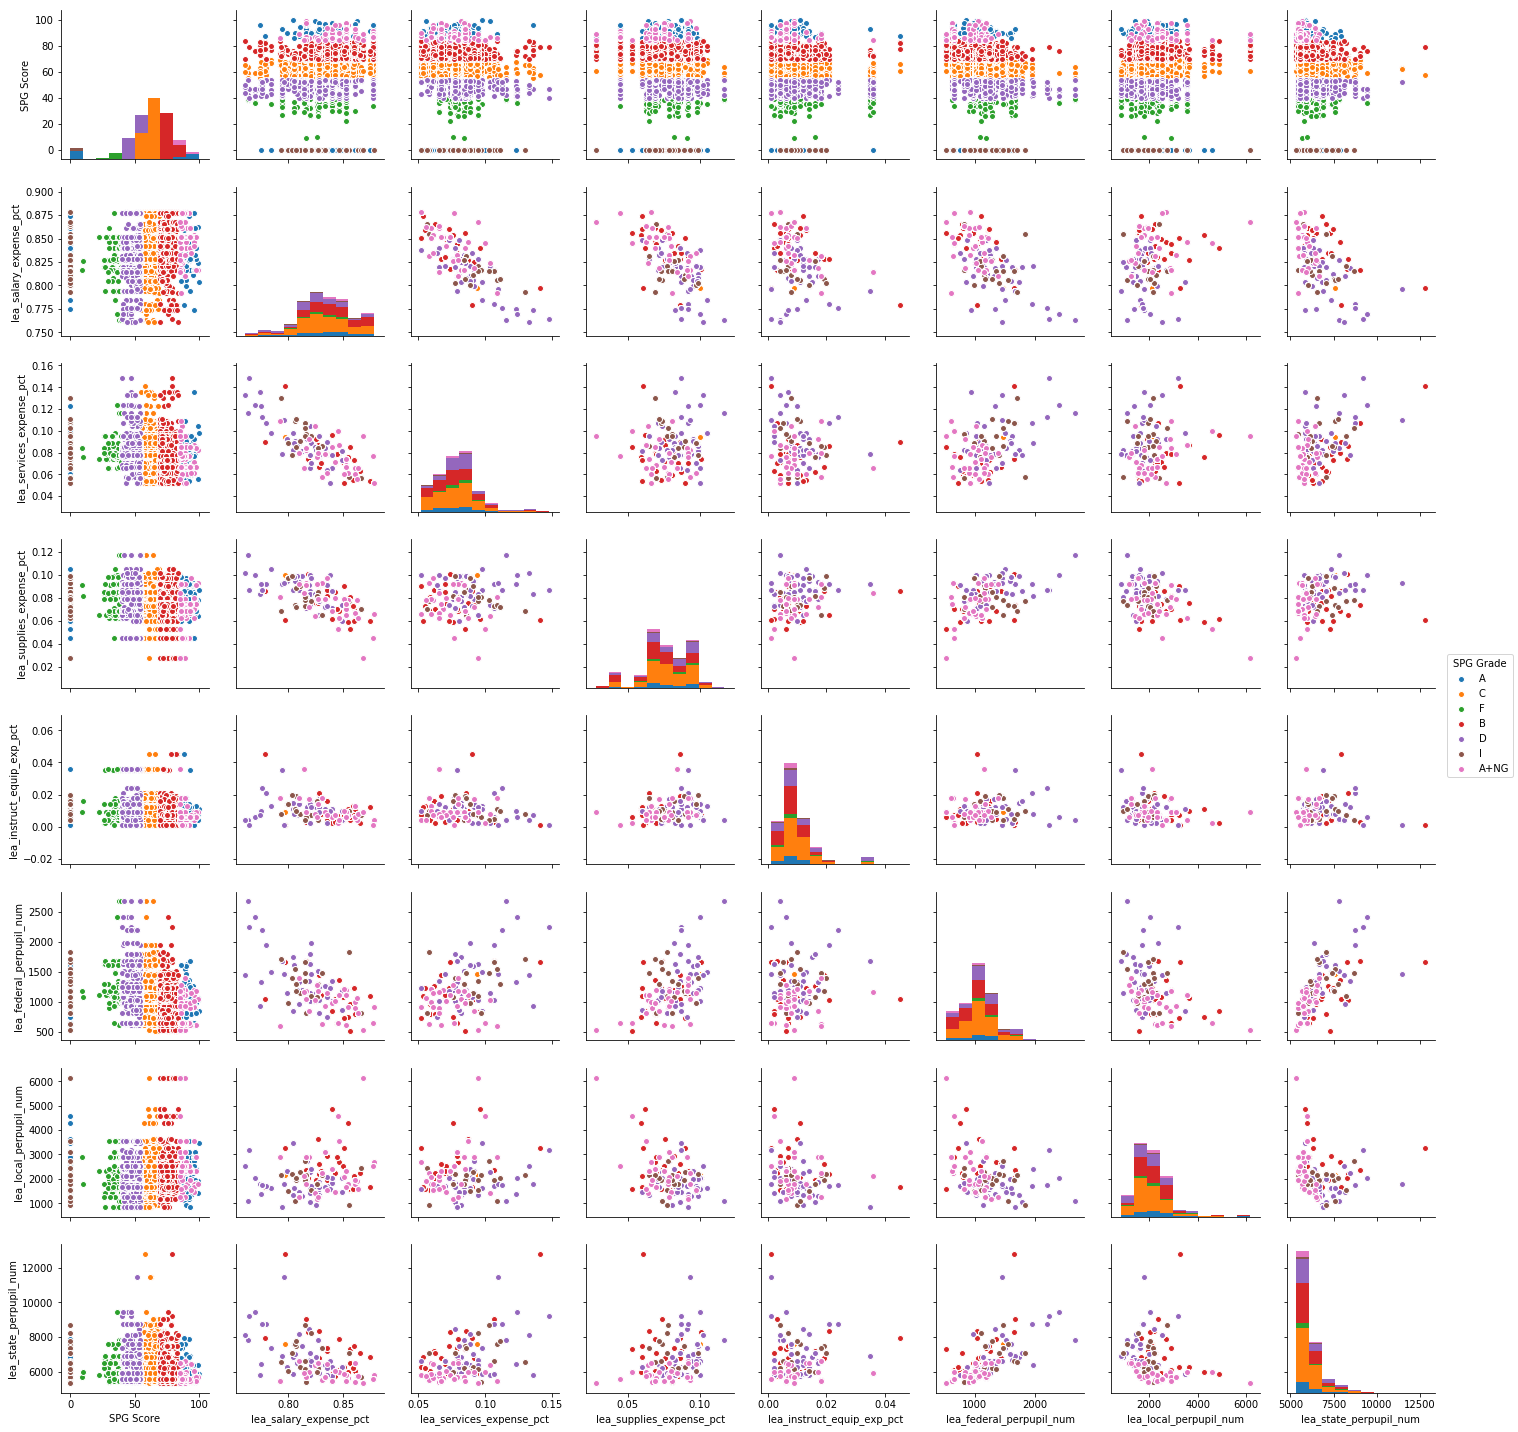

In [42]:
expense=school_data[['SPG Score', 'SPG Grade', 'lea_salary_expense_pct', 'lea_services_expense_pct',
                     'lea_supplies_expense_pct', 'lea_instruct_equip_exp_pct','lea_federal_perpupil_num', 
                     'lea_local_perpupil_num', 'lea_state_perpupil_num']]


sns.pairplot(expense, hue='SPG Grade');

## Relationships between the percentage of races and SPG Score:
The below matrix scatter plot illustrate the relationship of individual races with school performance grade. Schools with high percentages of Asians have higher grades. 
Some studies shows that Asian American high school students have higher grade point average and SAT scores than other high school students. it might be due to their culture and family expectation.
We also see that there is a slight and weak negetive correlation between school performance grade and the percentage of black and hispanic studnents.

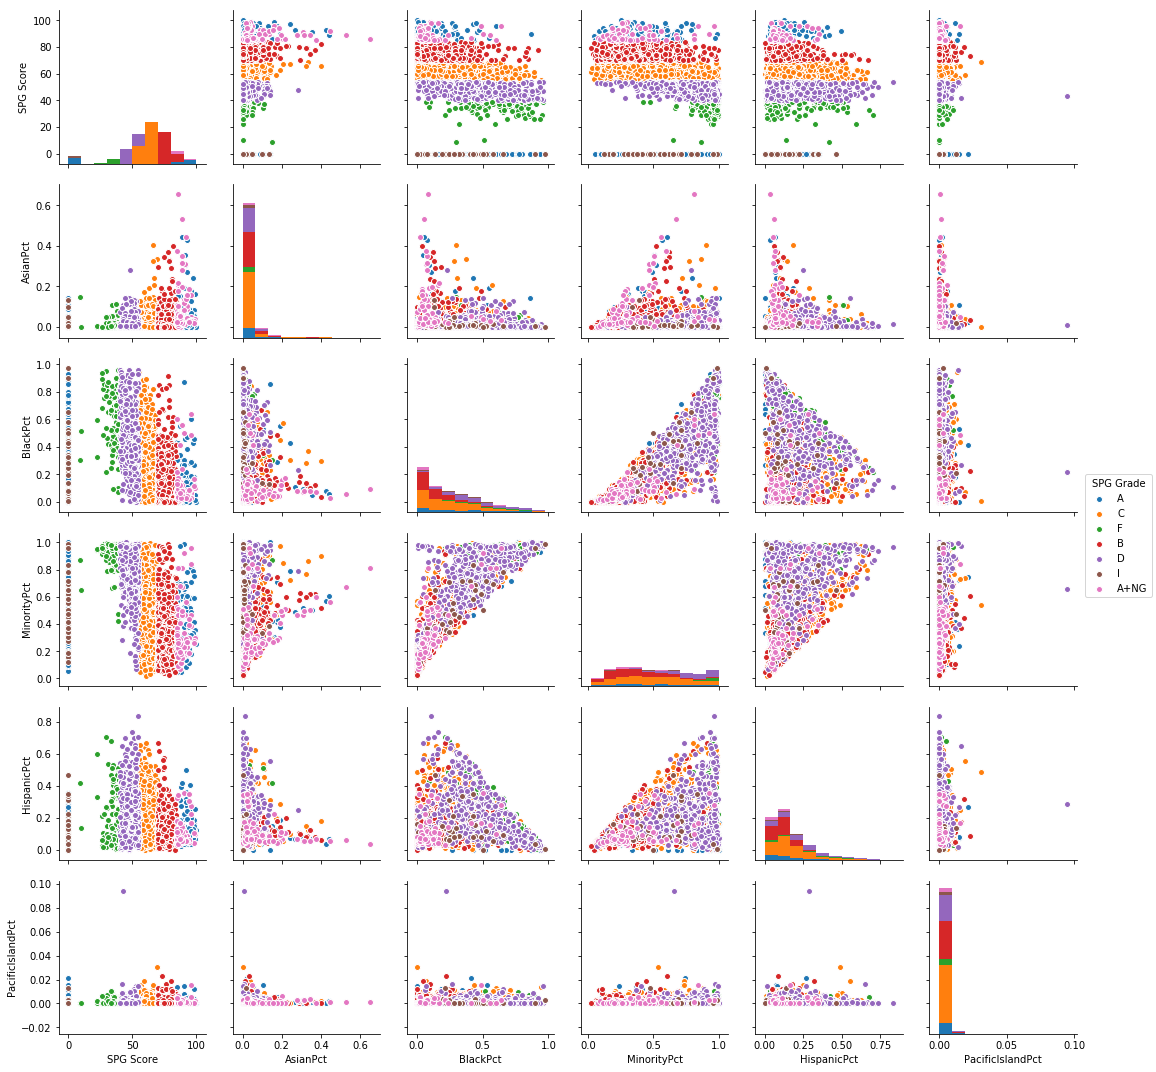

In [43]:
minority=school_data[['SPG Score', 'SPG Grade', 'AsianPct', 'BlackPct', 
                      'MinorityPct', 'HispanicPct', 'PacificIslandPct']]
sns.pairplot(minority, hue='SPG Grade');

## New Features:
In this study, there are some other new features that are created from the original variables. 
"SPG Grade" and "SPG": the categorical and continous variables created from SP Grade columns.
"AsianPct": the sum of Asian femail and male percentages
"BlackPct": the sum of black male and female percentages
"HispanicPct": the sum of Hispanic male and female percentages
"MinorityPct": the sum of minority male and female percentages
"PacificIslandPct": the sum of PacificIsland female and male percentages

# New Features

Are there other features that could be added to the data or created from existing features? Which ones?

In [44]:
#insert a new feature for SPG as continous values
school_data['SPG']=6
school_data['SPG'] = school_data['SPG Grade_A+NG']*7 + school_data['SPG Grade_B']*5 + school_data['SPG Grade_C']*4 + school_data['SPG Grade_D']*3 + school_data['SPG Grade_F']*2 + school_data['SPG Grade_I']*1

In [45]:
#Created new variables for different races - Combine the Male and Female for each race
school_data['AsianPct']=school_data['AsianFemalePct']+school_data['AsianMalePct']
school_data['BlackPct']=school_data['BlackFemalePct']+school_data['BlackMalePct']
school_data['HispanicPct']=school_data['HispanicFemalePct']+school_data['HispanicMalePct']
school_data['MinorityPct']=school_data['MinorityFemalePct']+school_data['MinorityMalePct']
school_data['PacificIslandPct']=school_data['PacificIslandFemalePct']+school_data['PacificIslandMalePct']

# Exceptional Work

You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.

PCA - extracting important variables (in form of components) from a large set of variables available in a data set.

when we have so many features, that means that we are working with high dimentional data. therefore we need to reduce our data dimentions. PCA is the Dimentionality reduction techniques that is very usefull in our project. There are 334 features, and only 2443 rows in the data set. Having too many features and limited data makes Principal Component Analysis a great candidate to find a model that predicts the NC school performance grades. We only consider the quantitative columns, and we would like to choose as many components as needed to explain around 80% of the SPG. Based on the variance explained graph, we must choose at least 62 principal components to explain 80% of the SPG. Variance explained graph illustrates the necessity of having 62 components to address 80% of the SPG.

The other dimentionality reduction technique is using Random Forest Classifier.
it lists the top 40 features along with their scores.

In [46]:
#split data into X and y dataframes

X = school_data.loc[:,school_data.dtypes==float]
y = school_data['SPG']

In [47]:
#split X and y into test and train sets.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [48]:
#applied a scaling procedure to scale the size of variables in the x dataframe

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [49]:
#run PCA on 62 components of the dataset, which explains 85% of the variance.

from sklearn.decomposition import PCA
pca = PCA(n_components=62)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
d = {'ratio':pca.explained_variance_ratio_,'total':pca.explained_variance_ratio_.cumsum()}

print(d)

{'ratio': array([0.21121389, 0.07191139, 0.05681174, 0.04667086, 0.03541681,
       0.02712559, 0.02485935, 0.02006729, 0.01943219, 0.01652025,
       0.01513793, 0.01404759, 0.01318802, 0.01240046, 0.01137073,
       0.01066397, 0.01034165, 0.00985162, 0.00895886, 0.00881854,
       0.00787344, 0.00747394, 0.0072491 , 0.0069681 , 0.00687565,
       0.00667942, 0.00658283, 0.00640573, 0.00601641, 0.0059094 ,
       0.00565805, 0.00554973, 0.00538425, 0.0053475 , 0.00512172,
       0.00497691, 0.00495199, 0.0049106 , 0.00459454, 0.00451257,
       0.00444367, 0.00429048, 0.00418138, 0.00408981, 0.00397262,
       0.00388082, 0.00381213, 0.00376957, 0.00359702, 0.00354   ,
       0.00342072, 0.00339027, 0.00332098, 0.00318027, 0.0031353 ,
       0.00309707, 0.00302064, 0.0029542 , 0.00287708, 0.00283974,
       0.0027672 , 0.00274502]), 'total': array([0.21121389, 0.28312528, 0.33993702, 0.38660788, 0.42202469,
       0.44915027, 0.47400962, 0.49407691, 0.51350911, 0.53002936,
       0.5

array([0.21121389, 0.07191139, 0.05681174, 0.04667086, 0.03541681,
       0.02712559, 0.02485935, 0.02006729, 0.01943219, 0.01652025,
       0.01513793, 0.01404759, 0.01318802, 0.01240046, 0.01137073,
       0.01066397, 0.01034165, 0.00985162, 0.00895886, 0.00881854,
       0.00787344, 0.00747394, 0.0072491 , 0.0069681 , 0.00687565,
       0.00667942, 0.00658283, 0.00640573, 0.00601641, 0.0059094 ,
       0.00565805, 0.00554973, 0.00538425, 0.0053475 , 0.00512172,
       0.00497691, 0.00495199, 0.0049106 , 0.00459454, 0.00451257,
       0.00444367, 0.00429048, 0.00418138, 0.00408981, 0.00397262,
       0.00388082, 0.00381213, 0.00376957, 0.00359702, 0.00354   ,
       0.00342072, 0.00339027, 0.00332098, 0.00318027, 0.0031353 ,
       0.00309707, 0.00302064, 0.0029542 , 0.00287708, 0.00283974,
       0.0027672 , 0.00274502])

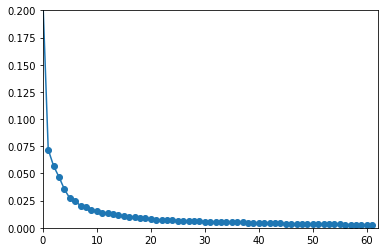

In [50]:
plt.plot(pca.explained_variance_ratio_, '-o')
plt.xlim(0,62)
plt.ylim(0,0.2)
pca.explained_variance_ratio_

In [51]:
#Run a Kfolds cross validation model on the data set and predicted y from the set

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.svm import LinearSVC
fold = KFold(len(y_train), n_folds=10, shuffle=True)
classifier = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=fold
        ,max_iter=4000
        ,fit_intercept=True
       ,solver='newton-cg')

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

C:\Python\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Python\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Python\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\util

In [52]:
#Created a confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[ 33   0   0   0   3   9   0]
 [  1   4   0   0   0   0   0]
 [  0   0   2  16   1   0   0]
 [  0   0   0  50  37   0   0]
 [  2   0   0  14 155  15   0]
 [  7   0   0   0  41  83   1]
 [  2   0   0   0   0  11   2]]


In [53]:
# Import `RandomForestClassifier`
from sklearn.ensemble import RandomForestClassifier

# Isolate Data, class labels and column values
X = school_data.iloc[:,0:40]
Y = school_data.iloc[:,-1]
names = school_data.columns.values

# Build the model
rfc = RandomForestClassifier()

# Fit the model
rfc.fit(X, Y)

# Print the results
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), names), reverse=True))


ValueError: Unknown label type: 'continuous'

## Tableau: AP Scores Vs Teacher Salaries 

Here we have an dual axis line graph demonstrating the relationship between AP score of 3 points or higher with the percent expenditure on teacher salaries. We can see some visual corrolation between rising scores and an increase in percentage. 

##Incase you don't have a Tableau account, I added a screenshot
<img src="files/Tableau_pic.jpg"> 


In [ ]:
%%HTML 

<script type='text/javascript' src='https://us-east-1.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1778px; height: 804px;'><object class='tableauViz' width='1778' height='804' style='display:none;'><param name='host_url' value='https%3A%2F%2Fus-east-1.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;murtshub' /><param name='name' value='APScoresVSTeachSalaries&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /><param name='display_spinner' value='no' /><param name='filter' value='iframeSizedToWindow=true' /></object></div>